# Objectives
## 1) Help find true love - through use of NLP I will match users based on their essay question responses.
## 2) Use Machine Learning to guess zodiac sign.

In recent years, there has been a massive rise in the usage of dating apps to find love. Many of these apps use sophisticated data science techniques to recommend possible matches to users and to optimize the user experience. These apps give us access to a wealth of information that we’ve never had before about how different people experience romance.

In this portfolio project, I will be using data from OKCupid, an app that focuses on using multiple choice and short answers to match users.

The dataset provided by OK Cupid has the following columns of multiple-choice data:

- body_type
- diet
- drinks
- drugs
- education
- ethnicity
- height
- income
- job
- offspring
- orientation
- pets
- religion
- sex
- sign
- smokes
- speaks
- status

And a set of open short-answer responses to :

- essay0 - My self summary
- essay1 - What I’m doing with my life
- essay2 - I’m really good at
- essay3 - The first thing people usually notice about me
- essay4 - Favorite books, movies, show, music, and food
- essay5 - The six things I could never do without
- essay6 - I spend a lot of time thinking about
- essay7 - On a typical Friday night I am
- essay8 - The most private thing I am willing to admit
- essay9 - You should message me if…

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
import re
import spacy
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_lg')

pd.options.display.max_columns = 50

In [2]:
df = pd.read_csv('profiles.csv')

In [3]:
df = df[:1000]

In [4]:
df.fillna('',axis=0,inplace=True)
df.rename(columns={'essay0': 'my_self', 'essay1': 'life', 'essay2': 'good_at', 'essay3': 'people_notice', 
                         'essay4': 'favorites', 'essay5': 'six_needed', 'essay6': 'think_to', 'essay7': 'friday_night', 
                         'essay8': 'private_admit', 'essay9': 'message_me_if'}, inplace=True)

## 1) Help Find True Love

### Preprocess Text

Since not all the essay questions are populated for every user I am going to consolidate them all into one column called Essay.

In [5]:
def essay_prep(data):
    
    data = data.str.replace("\n", " ", regex=False)
    data = data.str.replace(r"<[^>]*>", "", regex=True)
    data = data.str.replace(r'[^\w\s]', '', regex=True)
    data = data.str.lower()
    
    def remove_numbers(data):
        number_pattern = r'\d+'
        data = data.apply(
            lambda text: re.sub(pattern=number_pattern, repl=" ", string=text))
        return data
    
    data = remove_numbers(data)
    
    def remove_frequent_words(data):
        cnt = Counter()
        for text in data.values:
            for word in text.split(' '):
                cnt[word] += 1
        FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
        data = data.apply(
            lambda text: " ".join([word for word in str(text).split(' ') if word not in FREQWORDS]))
        return data

    data = remove_frequent_words(data)
    
    def lemmatize_words(data):
        lemmatizer = WordNetLemmatizer()
        data = data.apply(
            lambda text: " ".join([lemmatizer.lemmatize(word) for word in text.split()]))
        return data

    data = lemmatize_words(data)
    
    data = [nlp(data[x]) for x in range(len(data))]
    
    return data

In [6]:
essays_cols = df.columns.to_list()[6:16]

for col in essays_cols:
    df[col] = essay_prep(df[col])

In [7]:
userid = 0
essays_cols = df.columns.to_list()[6:16]

def find_best_match(data):
    essays_cols = data.columns.to_list()[6:16]
    temp_list = []
    def userid_v_others(data):
        for i in range(len(data)):
            temp_list.append(data[userid].similarity(data[i]))
        return temp_list

    for col in essays_cols:
        temp_list = []
        data[str(col)+'_score'] = userid_v_others(data[col])

    def orientation(data):
        if data.orientation.iloc[userid] == 'straight' and data.sex.iloc[userid] == 'm':
            return data[(data.orientation == 'straight') & (data.sex == 'f')]
        if data.orientation.iloc[userid] == 'straight' and data.sex.iloc[userid] == 'f':
            return data[(data.orientation == 'straight') & (data.sex == 'm')]
        elif data.orientation.iloc[userid] == 'gay' and data.sex.iloc[userid] == 'm':
            return data[(data.orientation == 'gay') & (data.sex == 'm')]
        elif data.orientation.iloc[userid] == 'gay' and data.sex.iloc[userid] == 'f':
            return data[(data.orientation == 'gay') & (data.sex == 'f')]
        elif data.orientation.iloc[userid] == 'bisexual':
            return data[data.orientation == 'bisexual']
        return data

    data = orientation(data)
    
    # Calculate Average Score of matched essays
    data['essay_match'] = data.iloc[: , -10:].mean(axis=1)
    
    # Sort top 10 highest match
    data = data.sort_values(['essay_match'],ascending=False).head()
    
    return data

In [8]:
best_match = find_best_match(df)

C:\Users\mrend\AppData\Local\Temp/ipykernel_3308/1144234782.py:9: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  temp_list.append(data[userid].similarity(data[i]))
C:\Users\mrend\AppData\Local\Temp/ipykernel_3308/1144234782.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['essay_match'] = data.iloc[: , -10:].mean(axis=1)


In [9]:
best_match.head(10)

,age,body_type,diet,drinks,drugs,education,my_self,life,good_at,people_notice,favorites,six_needed,think_to,friday_night,private_admit,message_me_if,ethnicity,height,income,job,last_online,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status,my_self_score,life_score,good_at_score,people_notice_score,favorites_score,six_needed_score,think_to_score,friday_night_score,private_admit_score,message_me_if_score,essay_match
209,30,thin,mostly anything,socially,never,working on college/university,"(me, what, more, do, you, want, like, pretty, ...","(am, student, at, local, community, college, b...","(love, loyalty, laughter, frequently, think, m...","(eye, are, blue, hair, is, partially, insert, ...","(book, currently, reading, girl, with, dragon,...","(this, includes, pet, mine, are, pretty, fanta...","(lot, stuff, thing, ohhhh, shiny, wonder, what...","(apparently, filling, essay, on, okcupid, when...","(am, giant, dork, wait, that, s, common, knowl...","(want, i, m, decently, awesome, bother, take, ...",white,66.0,-1,rather not say,2012-06-27-18-22,"menlo park, california",,straight,has dogs and has cats,agnosticism,f,gemini and it&rsquo;s fun to think about,no,english (fluently),seeing someone,0.980087,0.924784,0.802563,0.909458,0.893722,0.616122,0.594578,0.916096,0.786965,0.937325,0.836170
901,22,curvy,mostly vegetarian,socially,,working on college/university,"(hola, ola, hallo, kaixo, hafa, adai, bonjour,...","(am, one, year, away, from, obtaining, baccala...","(being, clumsy, procrastinating, laughing, wro...","(are, you, irish, is, your, hair, natural, lat...","(john, steinbeck, witch, portabello, george, o...","(soulful, people, sleep, color, book, water, c...","(human, existence, tend, overanalyze, thing, s...","(usually, begin, work, end, few, drink, few, s...","(have, an, account, on, dating, website)","(just, do, it, feel, so, inclined, know, what,...",white,67.0,-1,student,2012-04-07-16-10,"emeryville, california",,straight,,other,f,libra and it&rsquo;s fun to think about,trying to quit,"english (fluently), spanish (fluently), german...",single,0.948848,0.914731,0.851357,0.918548,0.884709,0.663778,0.697441,0.889922,0.689503,0.882886,0.834172
414,49,curvy,mostly other,socially,never,graduated from masters program,"(ok, here, enough, info, save, u, bunch, email...","(being, being, change, agent, being, present, ...","(stuff, previous, section, relationship, being...","(warm, eye, or, long, leg, if, wearing, dress,...","(book, nonfiction, elegant, universe, sacred, ...","(or, prefer, not, sunshine, outdoors, fresh, a...","(what, cat, is, trying, tell, me, quantum, phy...","(netflixg, at, rockin, kirtan, gardening, till...","(on, internet, life, need, way, more, laughter...","(you, re, fabulous, kisser, you, re, nonsmoker...",white,68.0,-1,other,2012-06-28-14-39,"san rafael, california","has a kid, but doesn&rsquo;t want more",straight,likes dogs and has cats,other but not too serious about it,f,virgo but it doesn&rsquo;t matter,no,english,single,0.980359,0.907115,0.842937,0.919109,0.883214,0.648222,0.617564,0.838999,0.777797,0.908977,0.832429
354,34,curvy,mostly anything,rarely,never,graduated from college/university,"(easy, going, usually, get, along, with, every...","(i, m, graphic, designer, work, local, printin...","(being, me, sound, conceded, but, it, true, ha...","(i, ve, gotten, two, response, this, eye, or, ...","(i, m, not, regular, reader, i, m, dyslexic, r...","(air, food, water, daylight)","(future, like, plan, thing, work, towards, goal)","(at, home, like, go, but, usually, friday, i, ...","(do, nt, know, depends, on, what, you, conside...","(interested, in, serious, relationship, do, nt...",white,68.0,40000,artistic / musical / writer,2012-06-28-21-42,"hayward, california","doesn&rsquo;t have kids, but wants them",straight,likes dogs and has cats,atheism,f,cancer but it doesn&rsquo;t matter,no,"english (fluently), spanish (fluently), french...",single,0.978616,0.929633,0.757444,0.896560,0

## 2) Predicting Zodiac Sign

Data cleanup for Zodiac Sign and Religion

In [10]:
df['sign'].unique()

array(['gemini', 'cancer', 'pisces but it doesn&rsquo;t matter', 'pisces',
       'aquarius', 'taurus', 'virgo', 'sagittarius',
       'gemini but it doesn&rsquo;t matter',
       'cancer but it doesn&rsquo;t matter',
       'leo but it doesn&rsquo;t matter', '',
       'aquarius but it doesn&rsquo;t matter',
       'aries and it&rsquo;s fun to think about',
       'libra but it doesn&rsquo;t matter',
       'pisces and it&rsquo;s fun to think about', 'libra',
       'taurus but it doesn&rsquo;t matter',
       'sagittarius but it doesn&rsquo;t matter',
       'scorpio and it matters a lot',
       'gemini and it&rsquo;s fun to think about',
       'leo and it&rsquo;s fun to think about',
       'cancer and it&rsquo;s fun to think about',
       'libra and it&rsquo;s fun to think about',
       'aquarius and it&rsquo;s fun to think about',
       'virgo but it doesn&rsquo;t matter',
       'scorpio and it&rsquo;s fun to think about',
       'capricorn but it doesn&rsquo;t matter', 'sco

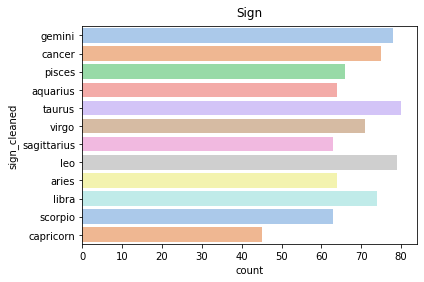

In [11]:
df['sign_cleaned'] = df.sign.str.split().str.get(0)
fig, ax = plt.subplots()
ax = sns.countplot(data = df, y = 'sign_cleaned', palette = 'pastel')
labels = [item.get_text() for item in ax.get_yticklabels()]
ax.set_title("Sign", pad=10)
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels, fontsize=10)
plt.show()

In [12]:
df['religion'].unique()

array(['agnosticism and very serious about it',
       'agnosticism but not too serious about it', '', 'atheism',
       'christianity', 'christianity but not too serious about it',
       'atheism and laughing about it',
       'christianity and very serious about it', 'other', 'catholicism',
       'catholicism but not too serious about it',
       'catholicism and somewhat serious about it',
       'agnosticism and somewhat serious about it',
       'catholicism and laughing about it',
       'agnosticism and laughing about it', 'agnosticism',
       'atheism and somewhat serious about it',
       'buddhism but not too serious about it',
       'other but not too serious about it', 'buddhism',
       'other and laughing about it',
       'judaism but not too serious about it',
       'buddhism and laughing about it',
       'other and somewhat serious about it',
       'other and very serious about it',
       'hinduism but not too serious about it',
       'atheism but not too seri

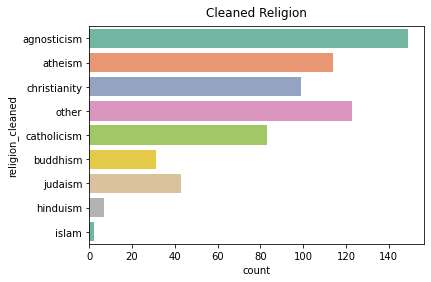

In [13]:
df['religion_cleaned'] = df.religion.str.split().str.get(0)
fig, ax = plt.subplots()
ax = sns.countplot(data = df, y = 'religion_cleaned', palette = 'Set2')
labels = [item.get_text() for item in ax.get_yticklabels()]
ax.set_title("Cleaned Religion", pad=10)
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels, fontsize=10)
plt.show()

# Machine Learning Models Training
In order to create a model that predict a zodiac sign for a user, only some features are used to create model. 

#### K Nearest Neighbors
#### Random Forest
#### Support Vector Machine

In [14]:
# import tools for preprocessing data
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

# Import machine learning model classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Import metrics for model evaluations
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import cross_val_score

#### Preprocessing Data
Section 1: Age and Categorical Columns

In [15]:
cols_to_classify = ['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'job' , 
                    'offspring', 'pets', 'smokes',  'religion_cleaned', 'sign_cleaned']

In [16]:
user_data = df[cols_to_classify]
user_data = user_data.dropna()
print(user_data.columns)
print(user_data.shape)

Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'job',
       'offspring', 'pets', 'smokes', 'religion_cleaned', 'sign_cleaned'],
      dtype='object')
(560, 12)


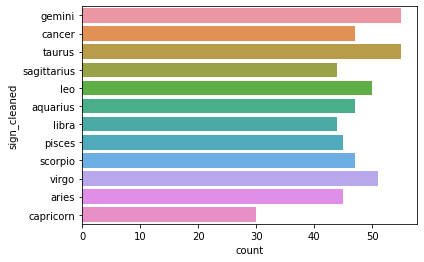

In [17]:
sns.countplot(data=user_data, y='sign_cleaned');

In [18]:
# split data into user and user_labels group
user = user_data.drop('sign_cleaned', axis=1)
user_labels = user_data['sign_cleaned'].copy()

# chage user_labels from text to number
le = LabelEncoder()
user_labels = le.fit_transform(user_labels)
user_labels[:5]

array([ 4,  2, 10,  8,  4])

In [19]:
le.classes_

array(['aquarius', 'aries', 'cancer', 'capricorn', 'gemini', 'leo',
       'libra', 'pisces', 'sagittarius', 'scorpio', 'taurus', 'virgo'],
      dtype=object)

In [20]:
# split data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(
    user, user_labels, test_size=0.2, random_state=33)

In [21]:
# prepare data using pipeline and column transformer
num_attr = ['age']
cat_attr = ['body_type', 'diet', 'drinks', 'drugs', 'education', 'job' , 'offspring', 'pets', 'smokes',  'religion_cleaned']
num_pipeline = Pipeline([('log_transform', FunctionTransformer(np.log)),('stdscaler', StandardScaler())])
cat_pipeline = Pipeline([('onehot', OneHotEncoder())])
full_pipeline = ColumnTransformer([('num', num_pipeline, num_attr), ('cat', cat_pipeline, cat_attr)])

In [22]:
X_prepared = full_pipeline.fit_transform(X_train)

In [23]:
X_prepared.toarray()

array([[-0.30347219,  1.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.18188364,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.04994927,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.06415569,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.85485021,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.69416148,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

# Training KNN Model Evaluation and Tuning

In [24]:
KNN_classifier = KNeighborsClassifier()

KNN_classifier.fit(X_prepared, y_train)
KNN_train_predictions = KNN_classifier.predict(X_prepared)
print(classification_report(y_train, KNN_train_predictions))

              precision    recall  f1-score   support

           0       0.24      0.50      0.32        40
           1       0.35      0.61      0.44        36
           2       0.17      0.21      0.19        38
           3       0.53      0.32      0.40        25
           4       0.34      0.29      0.32        41
           5       0.25      0.15      0.19        39
           6       0.38      0.32      0.35        37
           7       0.44      0.31      0.36        36
           8       0.44      0.35      0.39        34
           9       0.38      0.29      0.33        34
          10       0.30      0.28      0.29        46
          11       0.58      0.36      0.44        42

    accuracy                           0.33       448
   macro avg       0.37      0.33      0.34       448
weighted avg       0.36      0.33      0.33       448



The KNN model has average f1-score at 33%. However, this is the score on training data. The cross validation method would be used to see how the model works in generalizing.

In [25]:
# doing 5-folded cross validation and print out the f1_macro scores
print(cross_val_score(KNN_classifier, X_prepared, y_train, scoring='f1_macro', cv=5))

[0.06570973 0.01706349 0.08039126 0.05097354 0.05785771]


The KNN model works very bad on validation dataset. This might be caused by unappropriate k-value used in prediction. The default value of n_neighbors of KNeighborClassifier is 5. The model was trained with different k-values ranging from 1 to 20.

In [26]:
knn_scores = []
for k in range(1,21):
    KNN_classifier = KNeighborsClassifier(n_neighbors=k)
    KNN_classifier.fit(X_prepared, y_train)
    y_pred = KNN_classifier.predict(X_prepared)
    knn_scores.append(f1_score(y_train, y_pred, average='macro'))

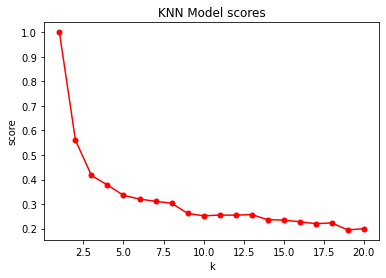

In [27]:
# plot the scores for each k
plt.plot(range(1,21), knn_scores, color='red', marker='o', markersize='5')
plt.title("KNN Model scores")
plt.xlabel("k")
plt.ylabel("score")
plt.show()

The model did not work well on the training data even though the k value was changed. The line graph indicates that the more k value is, the less model's score is.

# Training Random Forest Model

In [28]:
# create a Random Forest model classifier
RF_classifier = RandomForestClassifier()

RF_classifier.fit(X_prepared, y_train)
RF_train_predictions = RF_classifier.predict(X_prepared)
print(classification_report(y_train, RF_train_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        36
           2       1.00      1.00      1.00        38
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        41
           5       1.00      1.00      1.00        39
           6       1.00      1.00      1.00        37
           7       1.00      1.00      1.00        36
           8       1.00      1.00      1.00        34
           9       1.00      1.00      1.00        34
          10       1.00      1.00      1.00        46
          11       1.00      1.00      1.00        42

    accuracy                           1.00       448
   macro avg       1.00      1.00      1.00       448
weighted avg       1.00      1.00      1.00       448



It is clear that the model overfitted the training data. Therefore, the model was evaluated again by cross-validation.

In [29]:
# predict training labels for training data using RF_classifier
RF_cross_val_scores = cross_val_score(RF_classifier, X_prepared, y_train, scoring='f1_macro', cv=5)
print(RF_cross_val_scores)

[0.09910053 0.04184071 0.07691383 0.06054131 0.08109668]


In [30]:
np.mean(np.array([0.09135531, 0.06609432, 0.04631486, 0.05505279, 0.05621209]))

0.063005874

### Tuning Hyperparameters

As the random forest have some interesting hyperparameters such as max depth or max_features that can be adjusted, the GridSearchCV is used to tune those hyperparameters.

In [31]:
# check each estimator's max_depth
tree_max_depths = [estimator.tree_.max_depth for estimator in RF_classifier.estimators_]
print(tree_max_depths)

[31, 25, 35, 31, 33, 37, 29, 33, 36, 31, 31, 31, 33, 36, 33, 30, 31, 32, 39, 33, 32, 27, 31, 22, 27, 38, 29, 32, 26, 29, 35, 35, 37, 27, 37, 25, 29, 33, 27, 26, 32, 32, 27, 30, 28, 34, 28, 27, 35, 29, 33, 31, 33, 25, 35, 36, 33, 31, 27, 30, 38, 27, 38, 31, 27, 30, 30, 24, 33, 33, 31, 37, 38, 31, 35, 23, 29, 32, 35, 27, 28, 29, 34, 33, 29, 32, 29, 32, 41, 25, 31, 31, 29, 30, 34, 27, 30, 37, 27, 25]


In [32]:
from sklearn.model_selection import GridSearchCV
 
params = {'max_depth': [5,10,15,20], 
         'n_estimators':[100, 150, 200], 
          'max_features': ['auto', None],
          'bootstrap':[False],
          'min_samples_split': [100, 150, 200]}
grid_search = GridSearchCV(RF_classifier, params, cv=5)
grid_search.fit(X_prepared, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [False], 'max_depth': [5, 10, 15, 20],
                         'max_features': ['auto', None],
                         'min_samples_split': [100, 150, 200],
                         'n_estimators': [100, 150, 200]})

In [33]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_split': 100,
 'n_estimators': 100}

In [34]:
grid_search.best_score_

0.10941323345817729

Even though the hyperparameters were changed to other values in GridSearchCV, the best score from the best parameters tried was only 10%. The Random Forest model is not good enough for sign prediction.

# Training Support Vector Machine Model

In [35]:
SVM_classifier = SVC()

SVM_classifier.fit(X_prepared, y_train)
SVM_train_predictions = SVM_classifier.predict(X_prepared)

In [36]:
print(classification_report(y_train, SVM_train_predictions))

              precision    recall  f1-score   support

           0       0.63      0.78      0.70        40
           1       0.80      0.78      0.79        36
           2       0.82      0.71      0.76        38
           3       1.00      0.32      0.48        25
           4       0.71      0.78      0.74        41
           5       0.68      0.72      0.70        39
           6       0.96      0.73      0.83        37
           7       0.79      0.75      0.77        36
           8       0.79      0.68      0.73        34
           9       0.95      0.56      0.70        34
          10       0.60      0.93      0.73        46
          11       0.69      0.88      0.77        42

    accuracy                           0.74       448
   macro avg       0.79      0.72      0.73       448
weighted avg       0.77      0.74      0.73       448



In [37]:
# cross-validation
print(cross_val_score(SVM_classifier, X_prepared, y_train, scoring='f1_macro', cv=5))

[0.08051693 0.08820346 0.01926692 0.08121831 0.0779107 ]


In [38]:
np.mean(np.array([0.08051693, 0.08820346, 0.01926692, 0.08121831, 0.0779107]))

0.069423264

When looking at the first 1000 rows Support Vector Machine model predicted at 74%. Let's see if it does the same for 60,000 rows. 

# Conclusion

The three machine learning models cannot predict signs for users very well. For training data, K-Nearest Neighbors, Random Forest and SVM had f1-score at 33%, 100% (overfitting data) and 74% in turn. After testing on validation data via using cross-validation all the models cannot do better than guess which is around 8%.